# Query Log Analysis

The goal of this notebook is to serve as a way to quickly analyze a query log, based on the following aspects:

- Query-level
- Topic-level
- Session-level
- Term-level
- Entity-level

Our main focus is on understanding how people search, in order to improve entity-oriented search, thus we will tackle these aspects always around the entities.

**Requirements:**

- pandas
- numpy
- sklearn
- igraph
- progressbar2

**Suggestion:**

For better exploration and readability of this notebook install the extensions:
  
  - collapsible_headings
    ```sh
    pip install jupyter_contrib_nbextensions
    jupyter nbextension enable collapsible_headings/main
    ```
  - toc
    ```sh
    jupyter nbextension install --user https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.js
    jupyter nbextension enable toc
    ```

## Dependencies

In [256]:
import os
import codecs
import collections
import warnings
import progressbar

import igraph

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import naive_bayes

from joblib import Memory

## Settings

In [257]:
DEFAULT_FIGSIZE = [15, 3]
DEFAULT_MAX_ROWS = 8

plt.rc('figure', figsize=DEFAULT_FIGSIZE)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', DEFAULT_MAX_ROWS)

memory = Memory('output/cache', verbose=0)

## Utilities

In [258]:
def flatten(l, remove_none=True):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        elif not el is None:
            yield el

list(flatten([1,2,[4,5], [[6,7,None]], None]))

[1, 2, 4, 5, 6, 7]

# Datasets

While we take advantage of the Wikipedia query log for this analysis, we use an intermediate structure, so that you can convert your own query log into our format and analyze it. We begin by applying the analysis to the webis-smc-12 dataset, only then adapting the notebook for the Wikipedia query log.

The loader functions will be responsible for loading query log datasets and converting them into a Pandas DataFrame with the following valid columns (only columns with data are required):

- user_id
- query
- timestamp
- click_rank
- click_title
- click_url
- click_timestamp

## webis-smc-12
The Webis Search Mission Corpus 2012 (Webis-SMC-12) contains 8840 entries for 127 users. Each entry includes user ID, query, timestamp, rank and domain URL for clicked results, a mission ID and a comment. Each user is preceded by a line of dashes in the text file.

In [259]:
def load_webis_smc_12(path):
    """Load webis-smc-12.txt file into the notebook query log analysis format."""
   
    def date_parser(date_str):
        if type(date_str) is float and np.isnan(date_str):
            return np.nan
        else:
            return pd.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
    def get_sep_row_idx():
        sep_row_idx = []
        
        with open(path, "r") as fp:
            line_number = 0
            for line in fp:
                if line.startswith("---"):
                    sep_row_idx.append(line_number)
                line_number += 1
        
        return sep_row_idx
    
    df = pd.read_csv(
        'data/webis-smc-12.txt',
        sep='\t',
        lineterminator='\n',
        skiprows=get_sep_row_idx(),
        error_bad_lines=False,
        warn_bad_lines=False,
        parse_dates=['TimeStamp'],
        date_parser=date_parser)

    df.drop(columns=['MissionID', 'Comment'], inplace=True)
    
    df.rename(
        columns={
            'UserID': 'user_id',
            'Query': 'query',
            'TimeStamp': 'timestamp',
            'ClickRank': 'click_rank',
            'ClickDomain': 'click_url'
        },
        inplace=True)
    
    df.click_rank = df.click_rank.astype(pd.Int64Dtype())

    return df

## Data loading

Select one of the available dataset loading functions to begin the analysis:

- load_webis_smc_12

In [260]:
qlog = load_webis_smc_12('data/webis-smc-12.txt'); qlog

,user_id,query,timestamp,click_rank,click_url
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org
...,...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN
8835,24797984,fw signs from god,2006-05-29 15:44:27,NaN,NaN
8836,24797984,fw signs from god,2006-05-29 15:44:31,NaN,NaN
8837,24797984,fw signs from god,2006-05-29 15:44:38,NaN,NaN


# Query-level analysis

- Number of queries / interactions
- Number of distinct queries
- Distribution of number of queries / interactions per user
- Distribution of queries / interactions over time
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Total number of queries and distinct queries

In [261]:
qlevel_stats = pd.DataFrame(
    [qlog.shape[0], len(qlog['query'].unique())],
    columns=['value'],
    index=['num_queries', 'num_distinct_queries'])
qlevel_stats

,value
num_queries,8838
num_distinct_queries,3736


## Distribution of number of queries per user

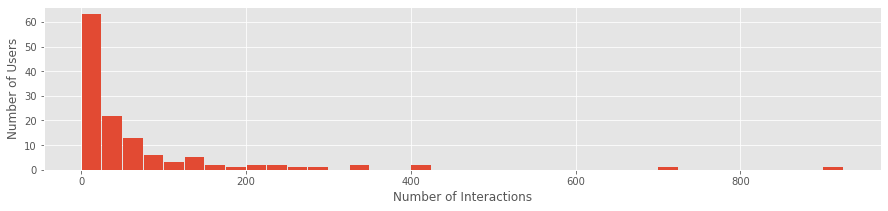

In [262]:
queries_per_user = qlog[['user_id', 'query']] \
    .groupby(['user_id']) \
    .count()

d_max = queries_per_user['query'].max()
bin_width = 25

queries_per_user \
    .plot(kind='hist', bins=range(0, d_max+bin_width, bin_width), rwidth=.95, legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

## Distribution of queries over time

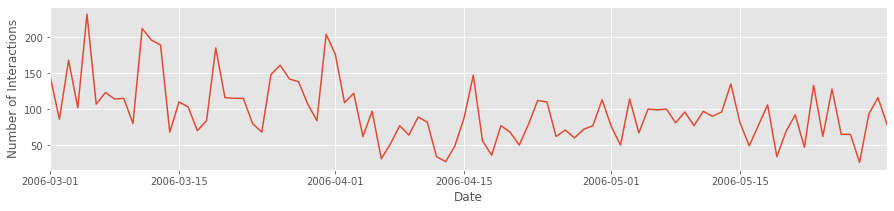

In [263]:
qlog['date'] = qlog['timestamp'].map(lambda t: t.date())

qlog \
    .groupby('date') \
    .size() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

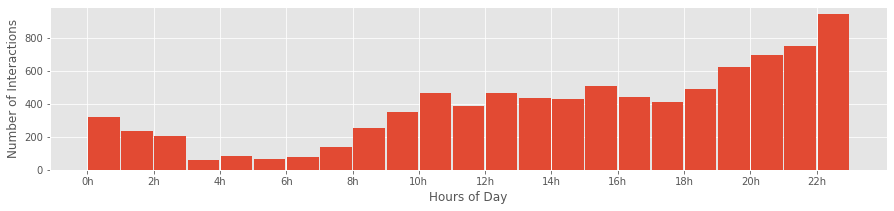

In [264]:
qlog['hour'] = qlog['timestamp'].map(lambda t: t.hour)
qlog['hour'] \
    .plot(kind='hist', bins=23, rwidth=.95)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)])
plt.xlabel('Hours of Day')
plt.ylabel('Number of Interactions')
plt.show()

### Per weekday cycles

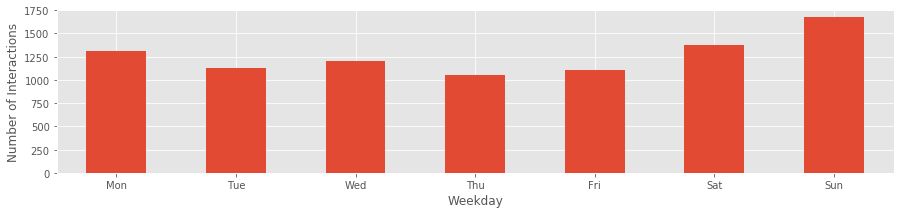

In [265]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
qlog['weekday'] = qlog['timestamp'].map(lambda t: t.weekday())

qlog \
    .groupby(['weekday']) \
    .size() \
    .plot(kind='bar')

plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel('Weekday')
plt.ylabel('Number of Interactions')
plt.show()

### Per monthly cycles

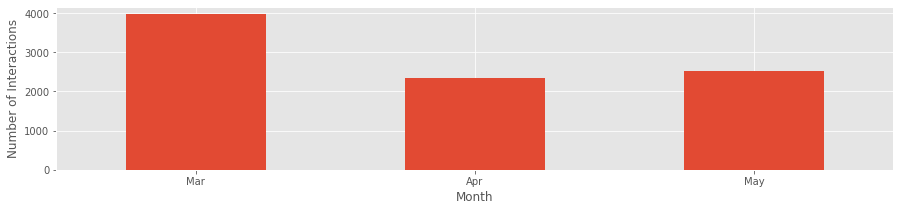

In [266]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
qlog['month'] = qlog['timestamp'].map(lambda t: t.month)

queries_per_month = qlog \
    .groupby(['month']) \
    .size() \

queries_per_month \
    .plot(kind='bar')

plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.show()

# Topic-level analysis

We will look at the categories (more general) and topics (more specific) of the query log, analyzing:

- Distribution of query categories
- Distribution of query topics


- Distribution of query categories over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles


- Distribution of query topics over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles

## Category detection

We train a classifier based on the [BBC dataset](http://mlg.ucd.ie/datasets/bbc.html), with 2225 documents and 5 categories:

- business
- entertainment
- politics
- sport
- tech

In [267]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_paths_per_class(bbc_base_dir):
    """Get dictionary of paths per class for BBC dataset."""
    
    bbc = {}
    
    for file in os.listdir(bbc_base_dir):
        class_path = os.path.join(bbc_base_dir, file)
        
        if os.path.isdir(class_path):
            label = file
            bbc[label] = []
            
            for file in os.listdir(class_path):
                doc_path = os.path.join(class_path, file)
                if os.path.isfile(doc_path):
                    bbc[label].append(doc_path)
    
    return bbc


def build_training_set(paths_per_class):
    """Load text documents per class and extract features (TF-IDF per term)."""

    vec = TfidfVectorizer(ngram_range=(1, 2))
    corpus = []
    y = []
    
    for label in paths_per_class.keys():
        for path in paths_per_class[label]:
            try:
                corpus.append(codecs.open(path, 'r', 'utf-8').read())
                y.append(label)
            except:
                print("==> Skipped %s" % (path))
        
    X = vec.fit_transform(corpus)
    return X, y, vec


def train(X, y):
    """
    Train a black box classifier. We chose Naïve Bayes here for returning a probability and having good proven
    performance on this dataset, as shown in: https://towardsdatascience.com/text-classification-in-python-dd95d264c802
    """
    nb = naive_bayes.MultinomialNB()
    nb.fit(X, y)
    return nb


def predict(models, docs, threshold=0.5):
    """
    Predict the correct class according to the probability. If no probability is above the threshold, then the class
    'unknown' is assigned instead.
    """
    predictions = []
    
    for label, model in models.items():
        predictions.append([label] + [p[0] for p in model.predict_proba(features_model.transform(docs))])
    
    cl_prob_per_doc = pd.DataFrame(predictions) \
        .rename({ 0: 'class', 1: 0, 2: 1 }, axis=1) \
        .set_index('class')
    
    cl_prob_per_doc.loc['unknown', :] = cl_prob_per_doc.max().lt(threshold).map(int)
    
    return cl_prob_per_doc.idxmax().tolist()


def select_training_set_for_class(X, y, label):
    """Deal with class imbalance problem by using stratified bootstrapping."""
    cl_idx = {}
    unique_y = np.unique(y)
    
    for u_cl in unique_y:
        if not u_cl in cl_idx:
            cl_idx[u_cl] = []
        cl_idx[u_cl].extend(idx for idx, cl in enumerate(y) if cl == u_cl)
   
    idx = cl_idx[label]
    n_samples = int(np.ceil( len(idx) / (len(unique_y) - 1) ))
    
    for cl in unique_y:
        idx.extend(np.random.choice(cl_idx[cl], n_samples, replace=True))
    
    return idx

In [268]:
paths_per_class = get_paths_per_class('data/bbc')
X, y, features_model = build_training_set(paths_per_class)

models = {}
for label in paths_per_class.keys():
    train_idx = select_training_set_for_class(X, y, label)
    models[label] = train(X[train_idx, :], [y[i] if y[i] == label else 'unknown' for i in train_idx])

==> Skipped data/bbc/sport/199.txt


It seems to work on the following two test queries:

In [269]:
docs = ["government law", "soccer goal", "finance department", "computer science", "grammy award"]
predict(models, docs)

['politics', 'sport', 'business', 'tech', 'entertainment']

Let's also inspect some random rows to see if it makes sense.

In [270]:
qlog['category'] = predict(models, qlog['query']); qlog[['query', 'category']]

,query,category
0,maryland state police,politics
1,harford county sheriff,entertainment
2,aberdeen police department in maryland,politics
3,aberdeen police department in maryland,politics
...,...,...
8834,fw signs from god,business
8835,fw signs from god,business
8836,fw signs from god,business
8837,fw signs from god,business


In [271]:
qlog[['query', 'category']].iloc[np.random.choice(len(qlog), 10)]

,query,category
7289,philly fish guys,sport
5521,what monk armor should i get,politics
4118,mys',business
6658,colon,business
...,...,...
7321,pursuit force,business
4672,jacqueline bailey loan admin cf cci countrywide,business
2934,poker games,tech
6132,ipods,tech


Some queries were wrongly categorized, since the training set doesn't cover all categories and the classifier we used never returns a probability under 0.5 for all of the labels. This means it's unable to use the unknown category.

## Topic detection

Another approach is to instead use an unsupervised algorithm. Classical topic models like LDA would be adequate, if it weren't for the short length of the queries. There is, however, the [biterm topic model](https://dl.acm.org/citation.cfm?id=2488514), which is more adequate for shorter text. Another, even better, approach could be the [relational biterm topic model](https://academic.oup.com/comjnl/article-abstract/62/3/359/5005494?redirectedFrom=fulltext), but since we didn't find any implementation and don't want to implement it ourselves, we will experiment with the biterm topic model.

In [272]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM

vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(qlog['query']).toarray()

vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)

**Note:** The following code will take a while to run. It's a lot slower than training and predicting with Naïve Bayes. We cache the model, so that we can rerun the whole notebook. Delete `output/cache` to retrain with the same data, otherwise it's fine to leave the cache.

In [273]:
num_topics = 20

@memory.cache
def biterm_train(num_topics, vocabulary, biterms, iterations=100):
    btm = oBTM(num_topics=num_topics, V=vocab)
    topics = btm.fit_transform(biterms, iterations=iterations)
    return btm, topics

btm, topics = biterm_train(num_topics, vocab, biterms, iterations=100)

We now take the topic distribution over the vocabulary and keep the top five terms, with highest probability, per topic.

In [274]:
topic_names = []
for i in range(20):
    idx = btm.phi_wz[:, i].argsort()[::-1][:5]
    topic_names.append(' '.join(vocab[i] for i in idx))

qlog['topic'] = [topic_names[topics[i].argmax()] for i in range(len(qlog))]; qlog[['query', 'topic']]

,query,topic
0,maryland state police,new york lyrics department julius
1,harford county sheriff,california symptoms phone gay male
2,aberdeen police department in maryland,new york lyrics department julius
3,aberdeen police department in maryland,new york lyrics department julius
...,...,...
8834,fw signs from god,wars florida lyrics sex web
8835,fw signs from god,wars florida lyrics sex web
8836,fw signs from god,wars florida lyrics sex web
8837,fw signs from god,wars florida lyrics sex web


## Distribution of query categories

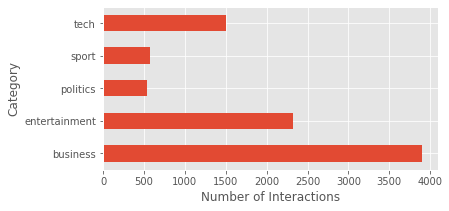

In [275]:
plt.rc('figure', figsize=[6, 3])

qlog[['query', 'category']] \
    .groupby('category') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Category')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Distribution of query topics

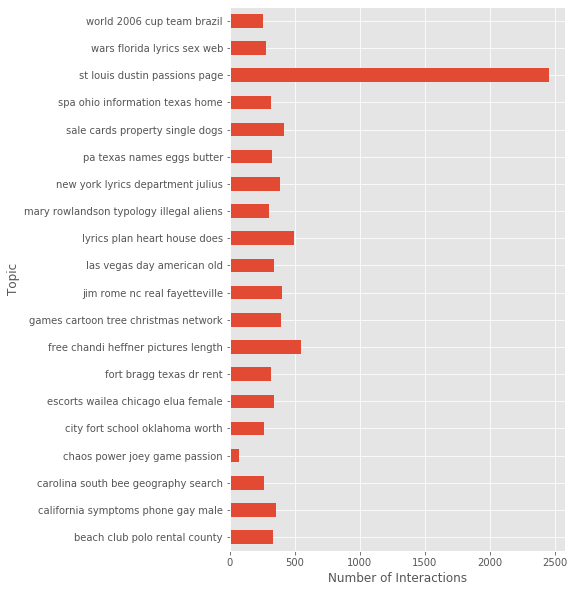

In [276]:
plt.rc('figure', figsize=[6, 10])

qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Topic')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Distribution of query categories over time

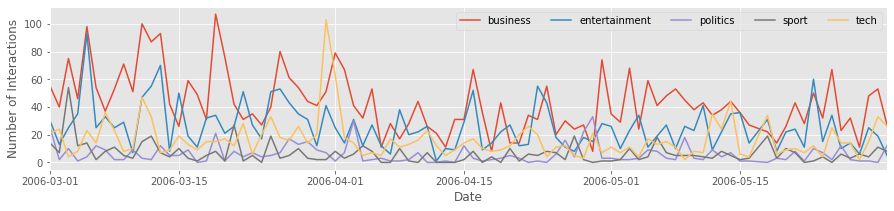

In [277]:
categories_over_time = qlog[['query', 'category', 'date']] \
    .groupby(['category', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

categories_over_time.plot()
plt.legend(loc='upper right', ncol=5)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

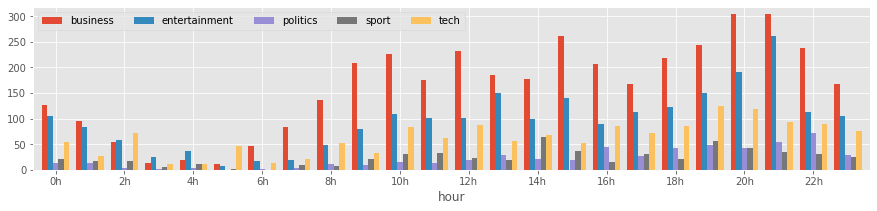

In [278]:
qlog[['query', 'category', 'hour']] \
    .groupby(['category', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

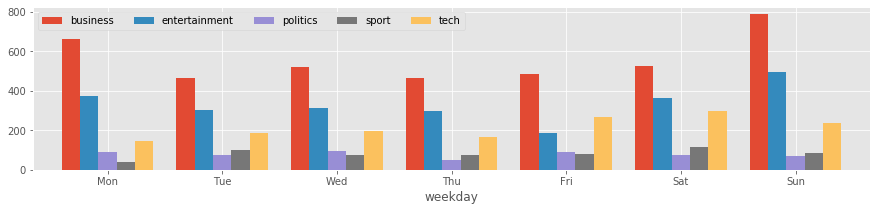

In [279]:
qlog[['query', 'category', 'weekday']] \
    .groupby(['category', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

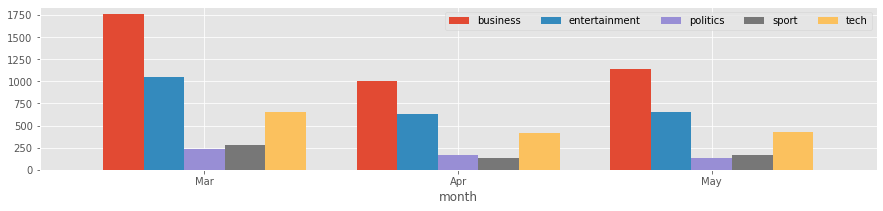

In [280]:
qlog[['query', 'category', 'month']] \
    .groupby(['category', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=6)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

## Distribution of query topics over time for top-4 topics

In [281]:
top_topics = qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .sort_values(by="query", ascending=False) \
    .rename({'query': 'count'}, axis=1) \
    .head(4)

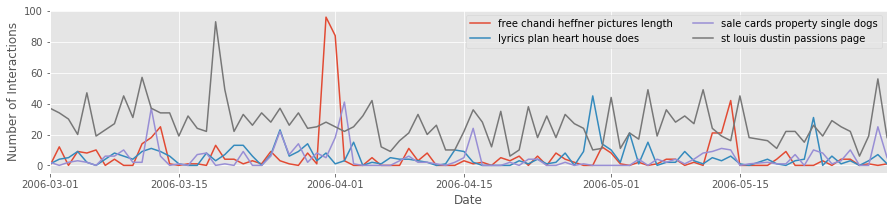

In [282]:
topics_over_time = qlog[['query', 'topic', 'date']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

topics_over_time.plot()
plt.legend(loc='upper right', ncol=2)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

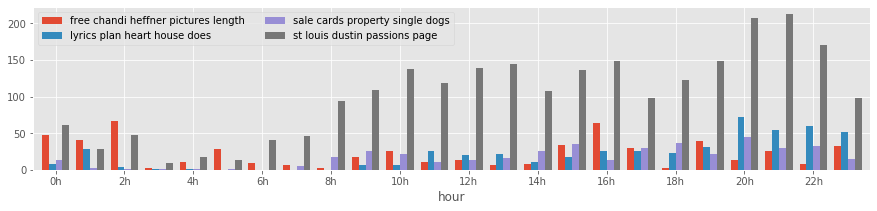

In [283]:
qlog[['topic', 'hour']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=2)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

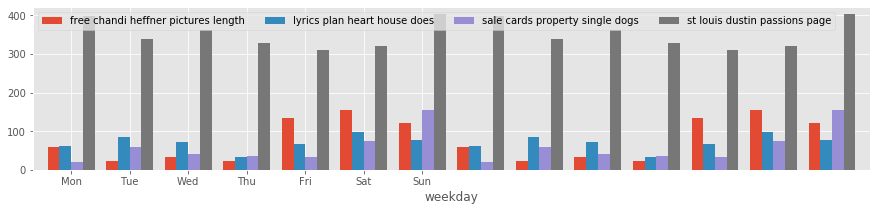

In [284]:
qlog[['query', 'topic', 'weekday']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=4)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

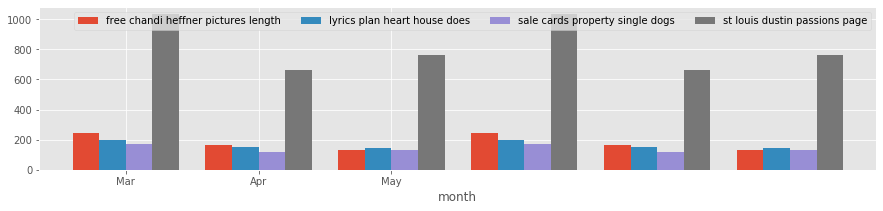

In [285]:
qlog[['query', 'topic', 'month']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=4)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

# Session-level analysis

- Number of queries / interactions per session
- Number of distinct queries per session
- Session duration distribution
- Distribution of number of clicks per session
- Average clicked rank per session duration


- Average session duration:
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Detecting sessions

**Note:** Don't run the following code block if there is already a "session_id" column.

In [286]:
from datetime import timedelta

def detect_sessions(qlog, mins=30):
    qlog.drop('session_id', axis=1, errors='ignore', inplace=True)
    new_sessions = pd.Series([], dtype='int64')
    for _, user_qlog in qlog.sort_values(by=['user_id', 'timestamp']).groupby('user_id'):
        user_new_sessions = user_qlog.timestamp.gt(user_qlog.timestamp.shift() + timedelta(minutes=mins))
        user_new_sessions.iloc[0] = True
        new_sessions = new_sessions.append(user_new_sessions)
    return pd.concat([
        qlog.sort_values(by=['user_id', 'timestamp']),
        pd.DataFrame({ 'session_id': new_sessions.cumsum() })
    ], axis=1, sort=False)

qlog = detect_sessions(qlog); qlog[['user_id', 'query', 'timestamp', 'session_id']]

,user_id,query,timestamp,session_id
0,38534,maryland state police,2006-03-01 23:48:15,1
1,38534,harford county sheriff,2006-03-01 23:55:13,1
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1
...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,2546
8835,24797984,fw signs from god,2006-05-29 15:44:27,2546
8836,24797984,fw signs from god,2006-05-29 15:44:31,2546
8837,24797984,fw signs from god,2006-05-29 15:44:38,2546


## Number of interactions per session

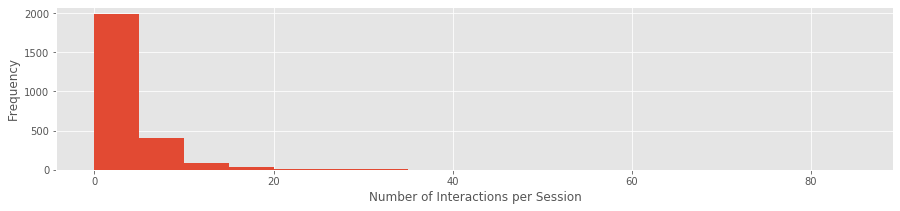

In [287]:
queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .count()

d_max = queries_per_session['query'].max()
bin_width = 5

queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Interactions per Session")
plt.ylabel("Frequency")
plt.show()

## Number of distinct queries per session

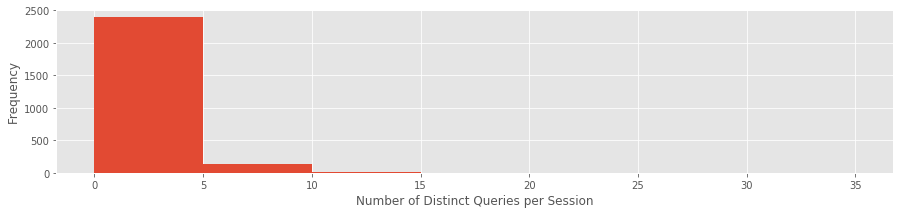

In [288]:
distinct_queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .nunique()

distinct_queries_per_session['session_id'] = distinct_queries_per_session.index
distinct_queries_per_session.drop('session_id', axis=1, inplace=True)
distinct_queries_per_session = distinct_queries_per_session.reset_index().drop('session_id', axis=1)

d_max = distinct_queries_per_session['query'].max()
bin_width = 5

distinct_queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Distinct Queries per Session")
plt.ylabel("Frequency")
plt.show()

## Session duration distribution

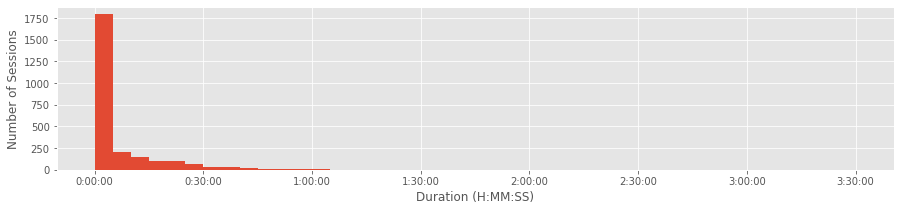

In [289]:
from matplotlib.ticker import FuncFormatter

session_durations = qlog[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1)

d_max = session_durations['duration'].max()
bin_width = 5/60

ax = session_durations \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: timedelta(seconds=x * 3600)))
plt.xlabel("Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of number of clicks per session

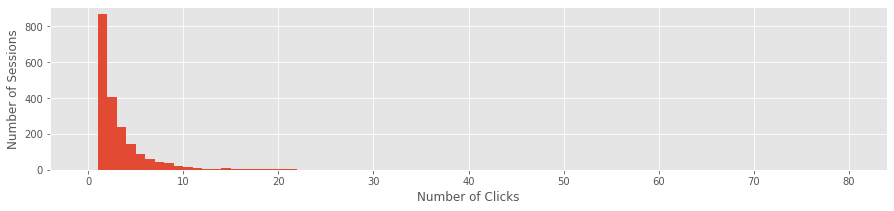

In [290]:
session_clicks = qlog[~qlog['click_rank'].isnull()][['session_id', 'click_rank']] \
    .groupby('session_id') \
    .count() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'click_count' }, axis=1)

d_max = session_clicks['click_count'].max()
bin_width = 1

session_clicks \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Number of Clicks")
plt.ylabel("Number of Sessions")
plt.show()

## Average session duration

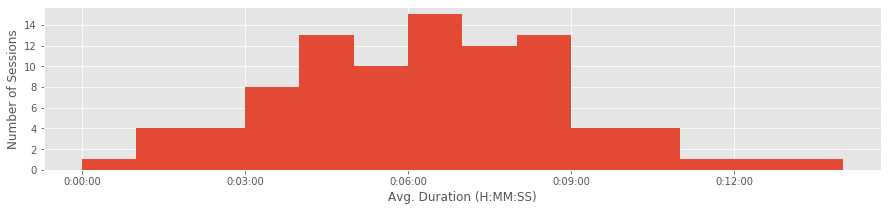

In [291]:
from matplotlib.ticker import FuncFormatter

session_durations_per_day = qlog[['session_id', 'date', 'timestamp']] \
    .groupby(['session_id', 'date']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('date') \
    .mean()

d_max = session_durations_per_day['duration'].max()
bin_width = 1/60

ax = session_durations_per_day \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=hour * 3600)))
plt.xlabel("Avg. Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

### Per 24h cycles

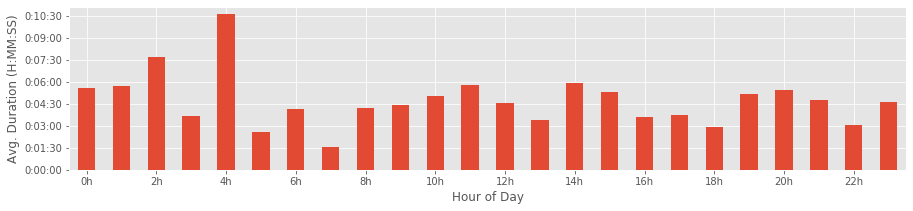

In [292]:
from matplotlib.ticker import FuncFormatter

session_durations_per_hour_of_day = qlog[['session_id', 'hour', 'timestamp']] \
    .groupby(['session_id', 'hour']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('hour') \
    .mean()

ax = session_durations_per_hour_of_day \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.xlabel("Hour of Day")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per weekday cycles

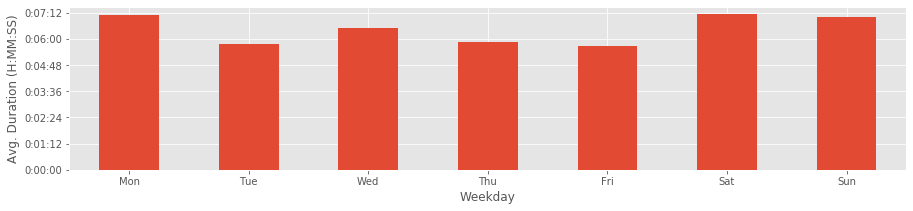

In [293]:
from matplotlib.ticker import FuncFormatter

session_durations_per_weekday = qlog[['session_id', 'weekday', 'timestamp']] \
    .groupby(['session_id', 'weekday']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('weekday') \
    .mean()

ax = session_durations_per_weekday \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel("Weekday")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per monthly cycles

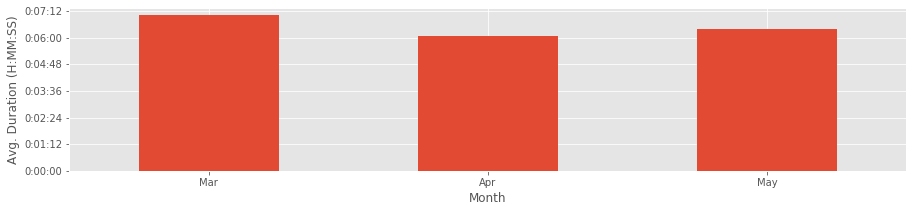

In [294]:
from matplotlib.ticker import FuncFormatter

session_durations_per_month = qlog[['session_id', 'month', 'timestamp']] \
    .groupby(['session_id', 'month']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('month') \
    .mean()

ax = session_durations_per_month \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

## Average clicked rank per session duration

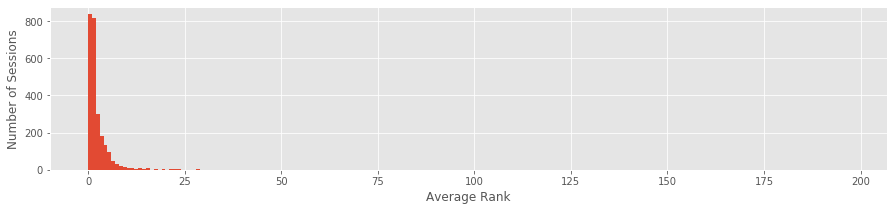

In [295]:
session_avg_rank = qlog[['session_id', 'click_rank']] \
    .fillna(0) \
    .groupby('session_id') \
    .mean() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'avg_rank' }, axis=1)

d_max = int(np.ceil(session_avg_rank['avg_rank'].max()))
bin_width = 1

session_avg_rank \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Average Rank")
plt.ylabel("Number of Sessions")
plt.show()

# Term-level analysis

The term-level analysis is concerned with the characteristics of the words that form the queries. Our analysis includes:

- Query length
  - Number of characters
  - Number of terms
- Term distribution
- Term popularity over time for top terms

## Query length

### Number of characters

In [296]:
qlog['length'] = qlog['query'].map(len); qlog[['query', 'length']]

,query,length
0,maryland state police,21
1,harford county sheriff,22
2,aberdeen police department in maryland,38
3,aberdeen police department in maryland,38
...,...,...
8834,fw signs from god,17
8835,fw signs from god,17
8836,fw signs from god,17
8837,fw signs from god,17


In [297]:
qlog['length'].describe()

count    8838.000000
mean       18.574904
std        10.300970
min         1.000000
25%        11.000000
50%        16.000000
75%        24.000000
max        96.000000
Name: length, dtype: float64

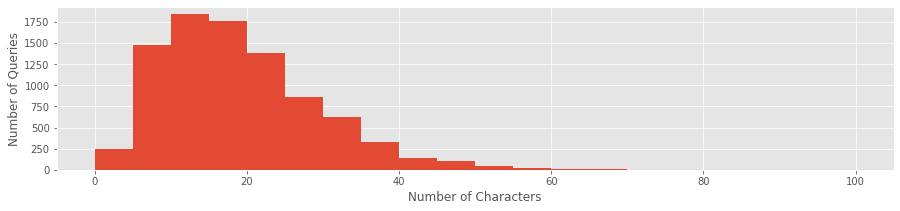

In [298]:
d_max = qlog['length'].max()
bin_width = 5

qlog['length'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel("Number of Characters")
plt.ylabel("Number of Queries")
plt.show()

### Number of terms

In [299]:
qlog['terms'] = qlog['query'].map(lambda q: q.split()); qlog[['query', 'terms']]

,query,terms
0,maryland state police,"[maryland, state, police]"
1,harford county sheriff,"[harford, county, sheriff]"
2,aberdeen police department in maryland,"[aberdeen, police, department, in, maryland]"
3,aberdeen police department in maryland,"[aberdeen, police, department, in, maryland]"
...,...,...
8834,fw signs from god,"[fw, signs, from, god]"
8835,fw signs from god,"[fw, signs, from, god]"
8836,fw signs from god,"[fw, signs, from, god]"
8837,fw signs from god,"[fw, signs, from, god]"


In [300]:
qlog['num_terms'] = qlog['terms'].map(len); qlog[['query', 'num_terms']]

,query,num_terms
0,maryland state police,3
1,harford county sheriff,3
2,aberdeen police department in maryland,5
3,aberdeen police department in maryland,5
...,...,...
8834,fw signs from god,4
8835,fw signs from god,4
8836,fw signs from god,4
8837,fw signs from god,4


In [301]:
qlog['num_terms'].describe()

count    8838.000000
mean        2.911858
std         1.699581
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: num_terms, dtype: float64

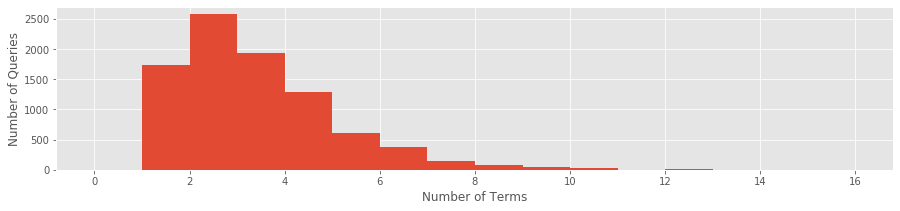

In [302]:
d_max = qlog['num_terms'].max()
bin_width = 1

qlog['num_terms'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel("Number of Terms")
plt.ylabel("Number of Queries")
plt.show()

## Term distribution

In [303]:
expanded_terms = qlog[['date', 'terms']] \
    .set_index('date')['terms'] \
    .apply(pd.Series) \
    .stack()

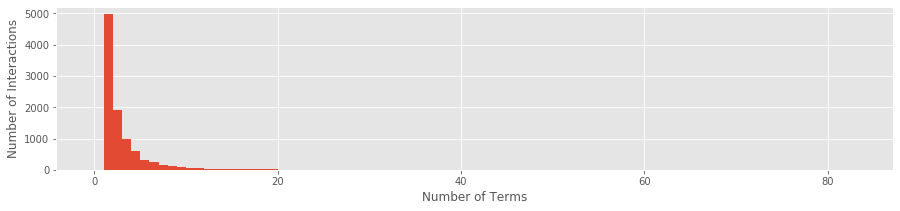

In [304]:
term_count = expanded_terms \
    .groupby('date') \
    .value_counts()

d_max = term_count.max()
bin_width = 1

term_count \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel('Number of Terms')
plt.ylabel('Number of Interactions')
plt.show()

## Term popularity over time for top 10 terms

In [305]:
from sklearn.feature_extraction import stop_words

vec = TfidfVectorizer()
X = vec.fit_transform(qlog['query'])
vocab = vec.get_feature_names()
top_terms = pd.DataFrame(X.toarray(), columns=vocab) \
    .drop(stop_words.ENGLISH_STOP_WORDS.intersection(vocab), axis=1) \
    .mean() \
    .sort_values(ascending=False)

top_terms[:5]

google       0.024779
gardenweb    0.012257
free         0.010483
lyrics       0.008693
cards        0.007693
dtype: float64

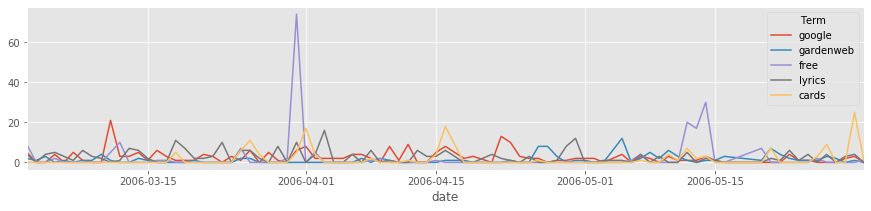

In [306]:
term_cout_over_time = pd.DataFrame(expanded_terms[expanded_terms.isin(top_terms[:5].index)], columns=['term']) \
    .reset_index() \
    .groupby(['date', 'term']) \
    .count() \
    .rename({'level_1': 'count'}, axis=1) \
    .unstack() \
    .fillna(0)

term_cout_over_time.columns = term_cout_over_time.columns.droplevel()

term_cout_over_time.loc[:, top_terms[:5].index] \
    .plot()
plt.legend(title='Term')
plt.show()

# Entity-level analysis

Our analysis of entities includes:

- Entity distribution per class
- Entity distribution over time for top entities

It also includes higher order analyses, further described in each of the following sections:

- Entity-query-level analysis
- Entity-topic-level analysis
- Entity-session-level analysis
- Entity-term-level analysis
- Entity-entity level analysis

## Detecting entities

We identified entities taking advantage of the `AhoCorasickEntityExtractor` class available in [Army ANT](https://github.com/feup-infolab/army-ant). We copied [aho_corasick_entity_extractor.py](../../edit/query_log_analysis/aho_corasick_entity_extractor.py) to the notebook workspace and edited it to be usable as a standalone dependency. We then used the English DBpedia `rdfs:label` for entities with the class `dbo:Person`, `dbo:Organisation` and `dbp:Place` as the dictionary.

In [307]:
from aho_corasick_entity_extractor import AhoCorasickEntityExtractor
ac = {
    'person': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_person.txt'),
    'organization': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_organization.txt'),
    'place': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_place.txt')
}

In [308]:
from collections import OrderedDict
from functools import reduce

for d_class in ac.keys():
    qlog[d_class] = None

    for i in range(len(qlog)):
        query = qlog.loc[i, 'query']
        entities = ac[d_class].extract(query)
        
        for entity in entities:
            if qlog.loc[i, d_class] is None:
                qlog.at[i, d_class] = [entity]
            else:
                qlog.at[i, d_class].append(entity)

qlog

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category,topic,session_id,length,terms,num_terms,person,organization,place
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics,new york lyrics department julius,1,21,"[maryland, state, police]",3,None,[police],[maryland]
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,entertainment,california symptoms phone gay male,1,22,"[harford, county, sheriff]",3,None,None,None
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,new york lyrics department julius,1,38,"[aberdeen, police, department, in, maryland]",5,None,"[aberdeen, police]","[aberdeen, maryland]"
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,new york lyrics department julius,1,38,"[aberdeen, police, department, in, maryland]",5,None,"[aberdeen, police]","[aberdeen, maryland]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business,wars florida lyrics sex web,2546,17,"[fw, signs, from, god]",4,None,None,None
8835,24797984,fw signs from god,2006-05-29 15:44:27,NaN,NaN,2006-05-29,15,0,5,business,wars florida lyrics sex web,2546,17,"[fw, signs, from, god]",4,None,None,None
8836,24797984,fw signs from god,2006-05-29 15:44:31,NaN,NaN,2006-05-29,15,0,5,business,wars florida lyrics sex web,2546,17,"[fw, signs, from, god]",4,None,None,None
8837,24797984,fw signs from god,2006-05-29 15:44:38,NaN,NaN,2006-05-29,15,0,5,business,wars florida lyrics sex web,2546,17,"[fw, signs, from, god]",4,None,None,None


In [309]:
import itertools

qlog_entities = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    entity_count = pd.DataFrame({
            'entity': list(itertools.chain(*filter(lambda d: d is not None, qlog[d_class]))),
            'class': d_class
        }) \
        .groupby(['entity', 'class']) \
        .size() \
        .reset_index() \
        .rename({0: 'count'}, axis='columns')
    
    qlog_entities = qlog_entities.append(entity_count)

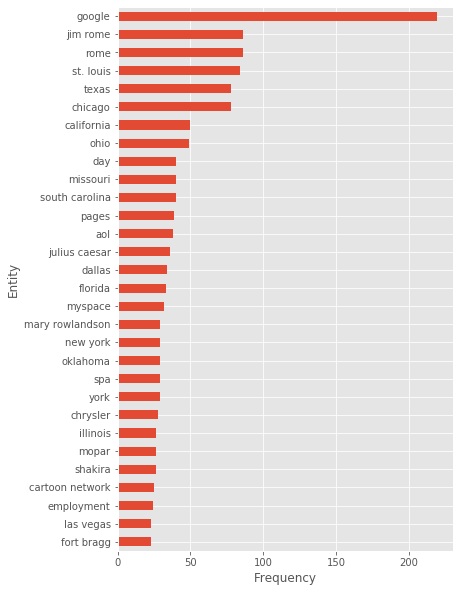

In [310]:
plt.rc('figure', figsize=[6, 10])

qlog_entities[['entity', 'count']] \
    .groupby('entity') \
    .sum() \
    .reset_index() \
    .sort_values(by='count', ascending=False) \
    .head(30) \
    .plot(kind='barh', x='entity', y='count', legend=False)

plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

In [311]:
def plot_entities_by_class(qlog_entities, d_class):
    plt.rc('figure', figsize=[6, 10])

    qlog_entities[qlog_entities['class'] == d_class] \
        .sort_values(by='count', ascending=False) \
        .head(30) \
        .plot(kind='barh', x='entity', y='count', legend=False)

    plt.xlabel('Frequency')
    plt.ylabel(d_class.title())
    plt.gca().invert_yaxis()
    plt.show()

    plt.rc('figure', figsize=DEFAULT_FIGSIZE)

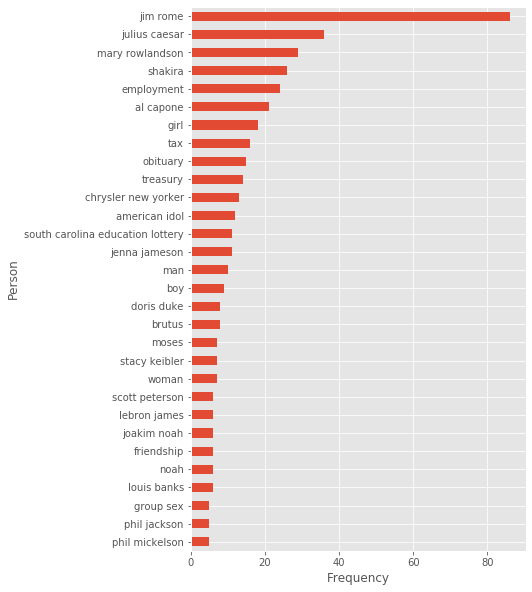

In [312]:
plot_entities_by_class(qlog_entities, 'person')

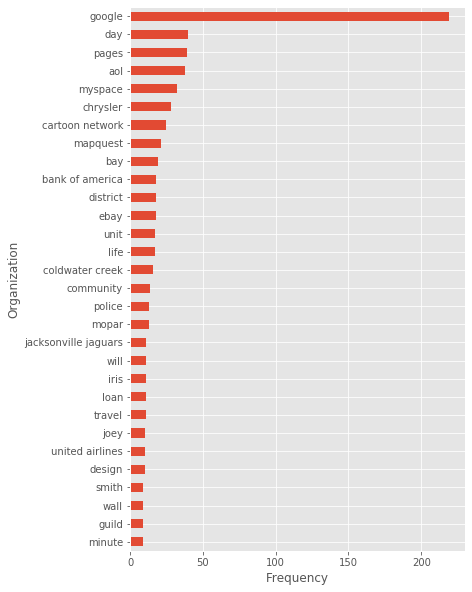

In [313]:
plot_entities_by_class(qlog_entities, 'organization')

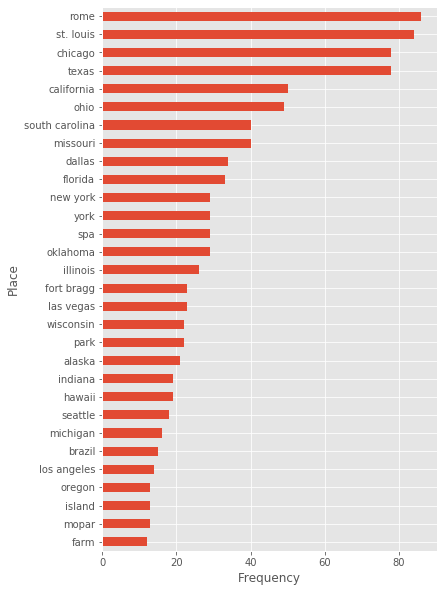

In [314]:
plot_entities_by_class(qlog_entities, 'place')

In the following sections, we expand the entity-level analysis by combining them with additional levels. In particular, we build local entity graphs from mentioned entities in a query, in queries with the same topic, or in a session to gain further insights into user search behavior.

## Building and characterizing entity graph from Simple Wikipedia

We use the [Simple English Wikipedia Link Graph with Clickstream Transitions 2018-12](https://rdm.inesctec.pt/dataset/cs-2018-004) to analyze the data from DBpedia. On one side, this graph only contains a low number of entities from Wikipedia. On the other side, it's easier to load and process in memory, conveniently supporting this analysis, that can later on be scaled up to a larger Wikipedia link graph.

In [315]:
g = igraph.read('data/simplewiki_link_graph-201812.gml', format='gml')
g.vs['label'] = [label.lower() for label in g.vs['label']]

In [316]:
g.vs['in'] = g.indegree()
g.vs['in'] = g.vs['in'] / np.sum(g.vs['in']) # indegree centrality (i.e., normalized)
g.vs['pr'] = g.pagerank()

In [317]:
@memory.cache
def compute_stats(graph=None, include_distance_based=False):
    if graph is None:
        graph = g
    
    components = graph.components()
    
    stats = {
        'vertices': graph.vcount(),
        'edges': graph.ecount(),
        'avg_clust_coef': graph.transitivity_undirected(),
        'density': graph.density(),
        'num_cc': len(components),
        'avg_cc_size': np.mean(components.sizes()),
        'stdev_cc_size': np.std(components.sizes())
    }
    
    if include_distance_based:
        stats['diameter'] = graph.diameter()
        stats['avg_path_len'] = graph.average_path_length()
    
    return pd.Series(stats)

g_stats = compute_stats(); g_stats.round(2)

vertices           897577.00
edges             6986460.00
avg_clust_coef          0.26
density                 0.00
num_cc             743499.00
avg_cc_size             1.21
stdev_cc_size         177.54
dtype: float64

## Building and visualizing entity subgraphs induced by a set of entities

We extract the induced entity subgraph for a set of entities, including all edges between the respective entity nodes. We also annotate and color source entity nodes, as well as shortest path edges (indiscriminately for any shortest path edges).

In [318]:
def entity_subgraph(entities, sample=None, ignore_warn=False):
    if sample is not None:
        entities = np.random.choice(list(entities), size=np.min([len(entities), sample]), replace=False)

    v_entities = g.vs.select(label_in=entities)
    
    s_paths = []
    for v_entity in v_entities:
        s_paths.extend(g.get_shortest_paths(v_entity, to=v_entities))

    sg = g.induced_subgraph([v for s_path in s_paths for v in s_path])
    
    sg.vs['is_source'] = False
    sg.vs['color'] = '#85c1e9'
    sg.es['arrow_size'] = 0.5

    sources = sg.vs.select(label_in=v_entities['label'])
    sources['is_source'] = True
    sources['color'] = '#f7dc6f'
    
    sp_edges = []
    for s_path in s_paths:
        if len(s_path) < 2:
            continue

        for s_idx, t_idx in zip(range(len(s_path)-1), range(1, len(s_path))):
            source = sg.vs.find(label=g.vs[s_path[s_idx]]['label'])
            target = sg.vs.find(label=g.vs[s_path[t_idx]]['label'])

            try:
                sp_edge = sg.es.find(_source=source.index, _target=target.index)
                sp_edge['arrow_size'] = 0.75
                sp_edge['width'] = 1.5
                sp_edge['color'] = '#f7dc6f'
                sp_edges.append(sp_edge)
            except:
                if not ignore_warn:
                    warnings.warn("Edge linking %s and %s not found" % (source['label'], target['label']))

    return sg

In [319]:
def plot_subgraph(sg, large=False):
    if large:
        bbox = (640, 480)
        margin = (50, 100, 50, 100)
    else:
        bbox = (320, 240)
        margin = (25, 50, 25, 50)

    return igraph.plot(sg, bbox=bbox, margin=margin, vertex_size=10, vertex_label_size=10, vertex_label_dist=1.5)

## Entity-query-level analysis

- Distribution of entities per query
- Distribution of global entity importance (PageRank) per query
- Distribution of local entity importance (PageRank) per query
- Distribution of queries per entity

### Distribution of entities per query

In [320]:
entities = qlog[['person', 'organization', 'place']].values.tolist()  # select all entity lists
entities = [[x if x else [] for x in d] for d in entities]            # replace None by empty list
entities = [[x for sl2 in sl for x in sl2 if sl2] for sl in entities] # flatten row lists

qlog['entities'] = None
for i, e in enumerate(entities):
    qlog.at[i, 'entities'] = e if len(e) > 0 else None

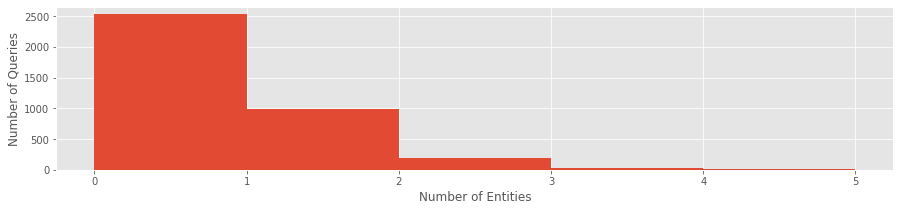

In [321]:
entities_per_query = qlog[['query', 'entities']] \
    .groupby('query') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

entities_per_query \
    .plot(kind='hist', bins=range(0, entities_per_query.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Queries")
plt.show()

### Preparing entity subgraphs per query

In [322]:
def entities_from_query(query):
    return set(flatten(
        qlog[qlog['query'] == query] \
            ['entities'].values.tolist()))

entities_from_query('aberdeen police department in maryland')

{'aberdeen', 'maryland', 'police'}

In [323]:
@memory.cache
def get_entity_subgraphs_by_query(queries):
    eg = {}
    for query in progressbar.progressbar(queries):
        entities = entities_from_query(query)
        if entities:
            eg[query] = entity_subgraph(entities, ignore_warn=True)
            eg[query].vs['lpr'] = eg[query].pagerank()    
    return eg

eg = get_entity_subgraphs_by_query(qlog['query'].unique())

### Visualizing entity subgraphs for queries

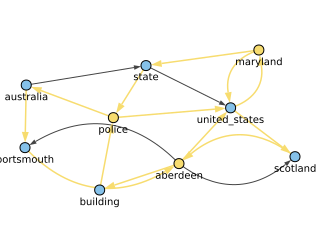

In [324]:
plot_subgraph(eg['aberdeen police department in maryland'])

### Distribution of global entity importance (PageRank) per query

In [325]:
all_queries_pr = pd.concat(
    pd.DataFrame({ 'query': query, 'pr': eg[query].vs['pr'], 'lpr': eg[query].vs['lpr'] })
    for query in eg.keys())

all_queries_pr = all_queries_pr \
    .groupby('query') \
    .mean()

all_queries_pr

,pr,lpr
query,,
10 passenger vans for rent in seattle wa. airport,0.000296,0.111111
10-99 tax form,0.000064,1.000000
1099 tax form,0.000064,1.000000
1966 chrysler,0.000007,1.000000
...,...,...
yochi designer dogs for sale,0.000005,1.000000
ywam canada,0.000468,1.000000
zion national park,0.000018,1.000000
zip codes in texas,0.000147,1.000000


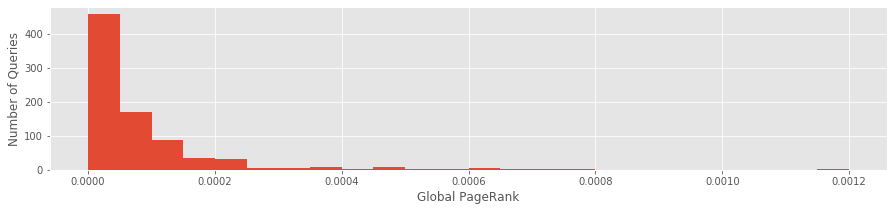

In [326]:
d_max = all_queries_pr['pr'].max()
bin_width = 0.00005

all_queries_pr['pr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Global PageRank')
plt.ylabel('Number of Queries')
plt.show()

### Distribution of local entity importance (PageRank) per query

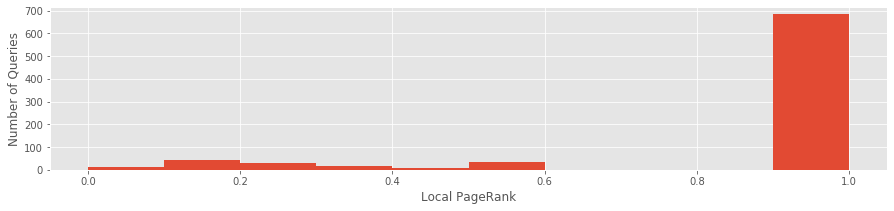

In [327]:
d_max = all_queries_pr['lpr'].max()
bin_width = 0.1

all_queries_pr['lpr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Local PageRank')
plt.ylabel('Number of Queries')
plt.show()

### Distribution of queries per entity (top 25)

In [328]:
queries_per_entity = qlog[['query', 'entities']] \
    .groupby('query') \
    .first() \
    .reset_index()

null_idx = queries_per_entity.index[queries_per_entity['entities'].isnull()]

for idx in null_idx:
    queries_per_entity['entities'].at[idx] = []

queries_per_entity = pd.DataFrame([
    (row.query, entity) for row in queries_per_entity.itertuples() for entity in row.entities],
    columns=['query', 'entity'])

queries_per_entity = queries_per_entity[['entity', 'query']] \
    .groupby('entity') \
    .count() \
    .sort_values(ascending=False, by='query') \
    .head(25)

queries_per_entity

,query
entity,
texas,47
st. louis,26
aol,26
california,24
...,...
michigan,10
mopar,10
fort bragg,10
myspace,9


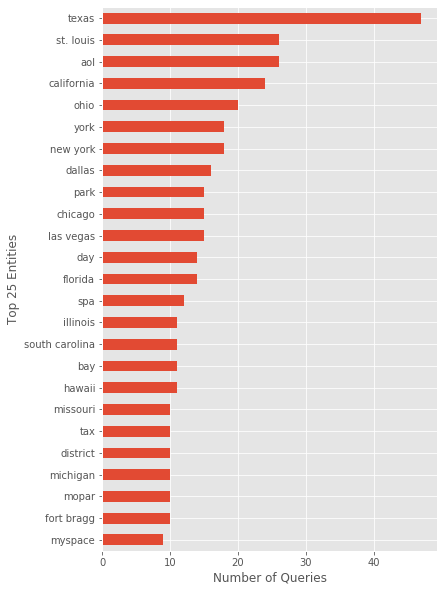

In [329]:
plt.rc('figure', figsize=[6, 10])

queries_per_entity['query'] \
    .plot(kind='barh')
plt.xlabel('Number of Queries')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Entity-topic-level analysis

- Distribution of entities per category
- Distribution of entity importance (PageRank) per category
- Distribution of categories per entity


- Distribution of entities per topic
- Distribution of distinct entities per topic
- Distribution of entity importance (PageRank) per topic
- Distribution of topics per entity

### Categories

#### Distribution of entities per category

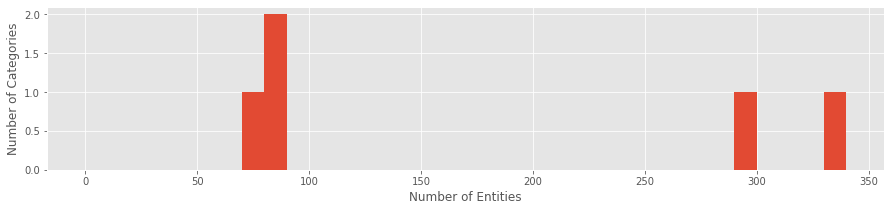

In [330]:
entities_per_category = qlog[['category', 'entities']] \
    .groupby('category') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_category \
    .plot(kind='hist', bins=range(0, entities_per_category.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Categories")
plt.show()

#### Preparing entity subgraphs per category

In [331]:
def entities_from_category(category):
    return set(flatten(
        qlog[qlog['category'] == category] \
            ['entities'].values.tolist()))

entities_from_category('business')

{'a house',
 'abraham',
 'agen',
 'aides',
 'air china',
 'al capone',
 'alabama',
 'alaska',
 'alterg',
 'american eagle outfitters',
 'american express',
 'annot',
 'aol',
 'arbonne',
 'arizona',
 'armenia',
 'azu',
 'bakassi',
 'bakery',
 'baltimore',
 'bank of america',
 'bay',
 'berlin',
 'berlin wall',
 'board of nursing',
 'borealis',
 'boston',
 'boy',
 'brentwood associates',
 'brooklyn',
 'brutus',
 'buffalo bills',
 'built to spill',
 'business',
 'california',
 'canada',
 'candle',
 'cardinal richelieu',
 'chad',
 'chevrolet',
 'chicago',
 'chief of staff',
 'china',
 'christian',
 'chrysler',
 'chrysler new yorker',
 'citgo',
 'cnn',
 'coldwater creek',
 'coldwell banker',
 'colombia',
 'colorado',
 'colorado bend state park',
 'comair',
 'community',
 'como',
 'company',
 'compost',
 'conor oberst',
 'cooking',
 'countrywide',
 'cowboy',
 'craigslist',
 'dallas',
 'day',
 'deepak chopra',
 'deevani',
 'del castillo',
 'delaware',
 'delbert mcclinton',
 'denver',
 'denver 

In [332]:
@memory.cache
def get_entity_subgraphs_by_category(categories, sample=None):
    eg = {}
    for category in progressbar.progressbar(categories):
        entities = entities_from_category(category)
        if entities:
            eg[category] = entity_subgraph(entities, sample=sample, ignore_warn=True)
            eg[category].vs['lpr'] = eg[category].pagerank()    
    return eg

eg = get_entity_subgraphs_by_category(qlog['category'].unique(), sample=100)

#### Distribution of global entity importance (PageRank) per category

In [333]:
all_categories_pr = pd.concat(
    pd.DataFrame({ 'category': category, 'pr': eg[category].vs['pr'], 'lpr': eg[category].vs['lpr'] })
    for category in eg.keys())

all_categories_pr

,category,pr,lpr
0,politics,2.450089e-04,0.003141
1,politics,4.568679e-05,0.000963
2,politics,2.497937e-05,0.001047
3,politics,5.858973e-05,0.000433
...,...,...,...
859,sport,6.619256e-07,0.000212
860,sport,6.497524e-07,0.000183
861,sport,8.140439e-07,0.000216
862,sport,7.751282e-07,0.000294


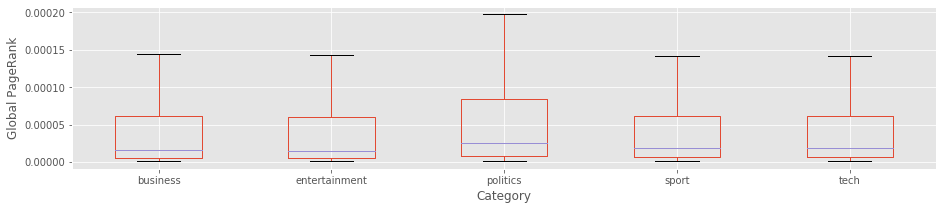

In [334]:
all_categories_pr[['category', 'pr']] \
    .boxplot(by='category', showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Global PageRank")
plt.show()

#### Distribution of local entity importance (PageRank) per category

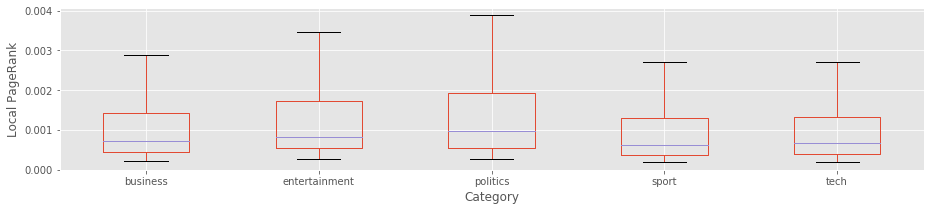

In [335]:
all_categories_pr[['category', 'lpr']] \
    .boxplot(by='category', showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Local PageRank")
plt.show()

#### Distribution of categories per entity (top 25)

In [336]:
categories_per_entity = qlog[['category', 'entities']]

null_idx = categories_per_entity.index[categories_per_entity['entities'].isnull()]

for idx in null_idx:
    categories_per_entity['entities'].at[idx] = []

categories_per_entity = pd.DataFrame([
    (row.category, entity) for row in categories_per_entity.itertuples() for entity in row.entities],
    columns=['category', 'entity'])

categories_per_entity = categories_per_entity[['entity', 'category']] \
    .groupby('entity') \
    .nunique()[['category']] \
    .sort_values(ascending=False, by="category") \
    .head(25)

categories_per_entity

,category
entity,
texas,5
dallas,5
michigan,5
california,5
...,...
canada,3
want,3
myspace,3
moon,3


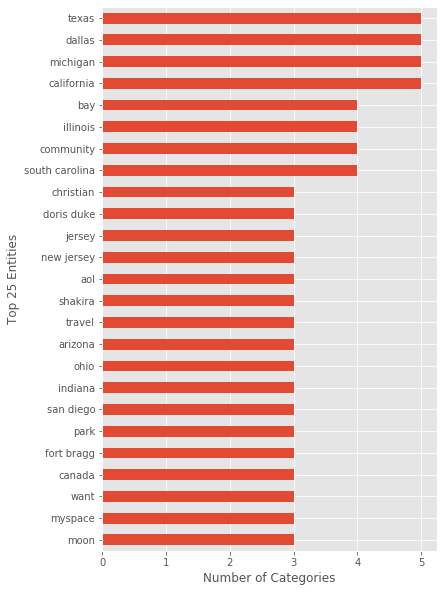

In [337]:
plt.rc('figure', figsize=[6, 10])

categories_per_entity['category'] \
    .plot(kind='barh')
plt.xlabel('Number of Categories')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Topics

#### Distribution of entities per topic

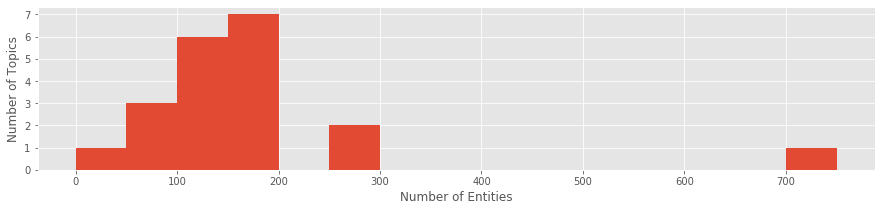

In [338]:
entities_per_topic = qlog[['topic', 'entities']] \
    .groupby('topic') \
    .apply(lambda df: len(list(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 50

entities_per_topic \
    .plot(kind='hist', bins=range(0, entities_per_topic.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Topics")
plt.show()

#### Distribution of distinct entities per topic

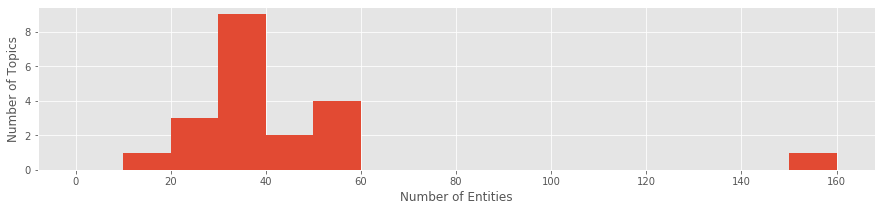

In [339]:
entities_per_topic = qlog[['topic', 'entities']] \
    .groupby('topic') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_topic \
    .plot(kind='hist', bins=range(0, entities_per_topic.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Topics")
plt.show()

#### Preparing entity subgraphs per topic

In [340]:
def entities_from_topic(topic):
    return set(flatten(
        qlog[qlog['topic'] == topic] \
            ['entities'].values.tolist()))

entities_from_topic('st louis dustin passions page')

{'aaliyah',
 'alabama',
 'alaska',
 'alterg',
 'anatomy',
 'aol',
 'arbonne',
 'armenia',
 'azu',
 'bakassi',
 'bank of america',
 'berlin',
 'berlin wall',
 'bill kirchen',
 'bon jovi',
 'boy',
 'brad stine',
 'cbs',
 'citgo',
 'cnn',
 'comair',
 'comme il faut',
 'community',
 'company',
 'compost',
 'conor oberst',
 'craigslist',
 'cross',
 'curtis',
 'curtis lemay',
 'dallas',
 'data',
 'de anza college',
 'deevani',
 'del castillo',
 'derby',
 'district',
 'ebay',
 'eeyore',
 'employment',
 'enterprise bank',
 'eros',
 'espn',
 'exploratorium',
 'extended stay america',
 'facebook',
 'fall out boy',
 'fall within',
 'finding',
 'florida',
 'fotos',
 'friendship',
 'gamestop',
 'geico',
 'girl',
 'google',
 'greenwich',
 'grow',
 'habitat',
 'heartland bank',
 'honda',
 'hospira',
 'hugo weaving',
 'james blunt',
 'james cagney',
 'james church',
 'james st. james',
 'java',
 'jay z',
 'jeep',
 'jena',
 'jimmy carter',
 'jon stewart',
 'julia ormond',
 'kelley blue book',
 'kentuck

In [341]:
@memory.cache
def get_entity_subgraphs_by_topic(topics):
    eg = {}
    for topic in progressbar.progressbar(topics):
        entities = entities_from_topic(topic)
        if entities:
            eg[topic] = entity_subgraph(entities, ignore_warn=True)
            eg[topic].vs['lpr'] = eg[topic].pagerank()    
    return eg

eg = get_entity_subgraphs_by_topic(qlog['topic'].unique())

#### Visualizing entity subgraphs for topics

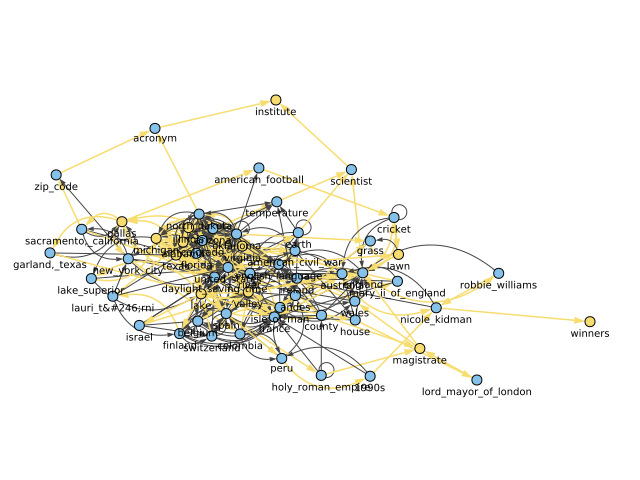

In [342]:
plot_subgraph(eg['carolina south bee geography search'], large=True)

#### Distribution of global entity importance (PageRank) per topic

In [343]:
all_topics_pr = pd.concat(
    pd.DataFrame({ 'topic': topic, 'pr': eg[topic].vs['pr'], 'lpr': eg[topic].vs['lpr'] })
    for topic in eg.keys())

all_topics_pr

,topic,pr,lpr
0,new york lyrics department julius,2.450089e-04,0.005248
1,new york lyrics department julius,2.497937e-05,0.003013
2,new york lyrics department julius,4.829241e-04,0.014375
3,new york lyrics department julius,1.767229e-04,0.015307
...,...,...,...
53,carolina south bee geography search,1.603665e-06,0.004629
54,carolina south bee geography search,4.994304e-06,0.009836
55,carolina south bee geography search,1.680782e-06,0.005571
56,carolina south bee geography search,6.807502e-07,0.007267


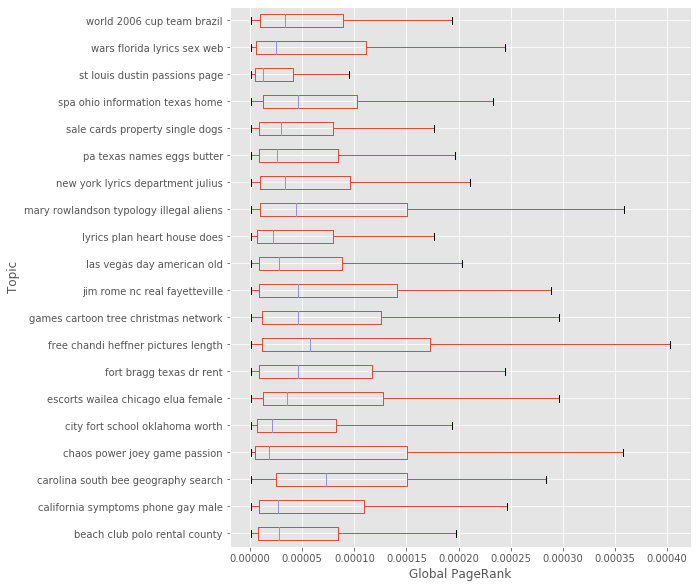

In [344]:
plt.rc('figure', figsize=[8, 10])

all_topics_pr[['topic', 'pr']] \
    .boxplot(by='topic', showfliers=False, vert=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Global PageRank")
plt.ylabel("Topic")
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

#### Distribution of local entity importance (PageRank) per topic

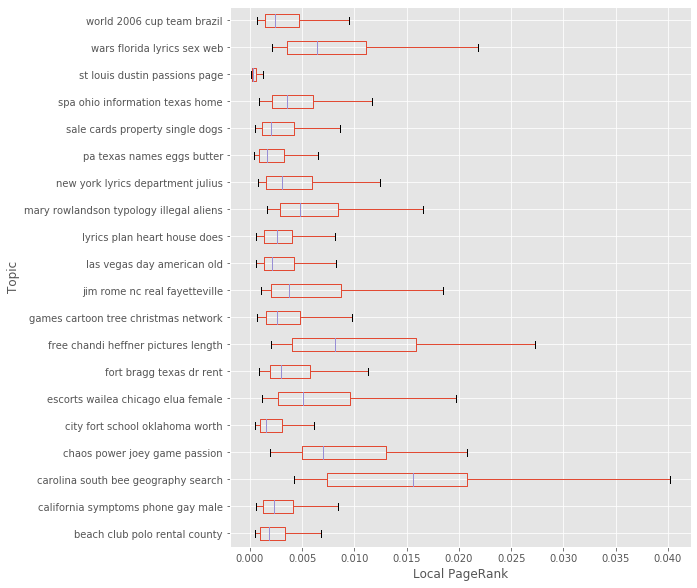

In [345]:
plt.rc('figure', figsize=[8, 10])

all_topics_pr[['topic', 'lpr']] \
    .boxplot(by='topic', showfliers=False, vert=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Local PageRank")
plt.ylabel("Topic")
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

#### Distribution of topics per entity (top 25)

In [346]:
topics_per_entity = qlog[['topic', 'entities']]

null_idx = topics_per_entity.index[topics_per_entity['entities'].isnull()]

for idx in null_idx:
    topics_per_entity['entities'].at[idx] = []

topics_per_entity = pd.DataFrame([
    (row.topic, entity) for row in topics_per_entity.itertuples() for entity in row.entities],
    columns=['topic', 'entity'])

topics_per_entity = topics_per_entity[['entity', 'topic']] \
    .groupby('entity') \
    .nunique()[['topic']] \
    .sort_values(ascending=False, by="topic") \
    .head(25)

topics_per_entity

,topic
entity,
florida,8
texas,7
dallas,7
park,6
...,...
day,3
nato,3
espn,3
boy,3


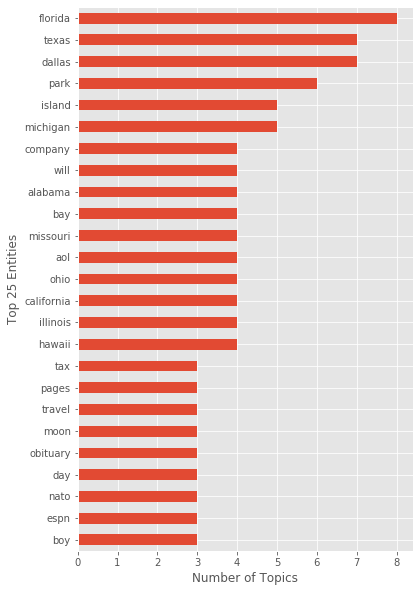

In [347]:
plt.rc('figure', figsize=[6, 10])

topics_per_entity['topic'] \
    .plot(kind='barh')
plt.xlabel('Number of Topics')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Entity-session-level analysis

- Distribution of entities per session
- Distribution of distinct entities per session
- Entity graphs for the top sessions with more entities:
  - Average distance between query entities
  - Global entity importance (PageRank)
  - Local entity importance (PageRank)
  - Global vs local PageRank
- Distribution of global entity importance (PageRank) per session
- Distribution of local entity importance (PageRank) per session

### Distribution of entities per session

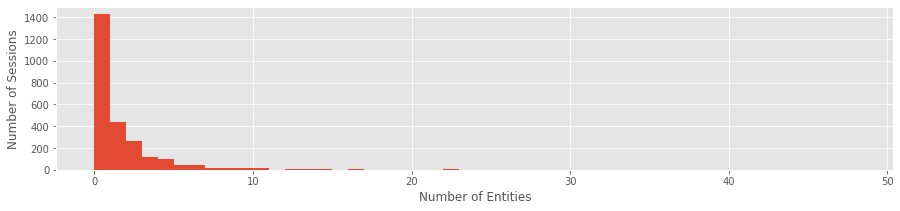

In [348]:
entities_per_session = qlog[['session_id', 'entities']] \
    .groupby('session_id') \
    .apply(lambda df: len(list(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

entities_per_session \
    .plot(kind='hist', bins=range(0, entities_per_session.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Sessions")
plt.show()

### Distribution of distinct entities per session

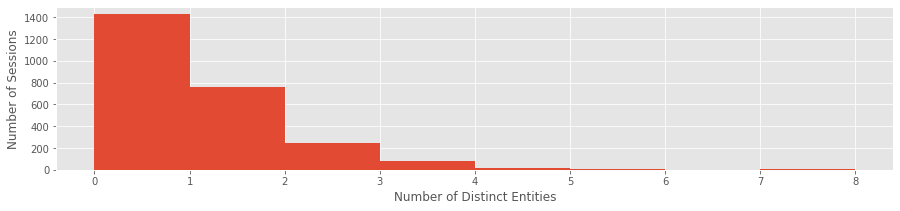

In [349]:
distinct_entities_per_session = qlog[['session_id', 'entities']] \
    .groupby('session_id') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

distinct_entities_per_session \
    .plot(kind='hist', bins=range(0, distinct_entities_per_session.max() + bin_width, bin_width))
plt.xlabel("Number of Distinct Entities")
plt.ylabel("Number of Sessions")
plt.show()

### Identifying the entities for the top sessions with distinct entities

In [350]:
top_sessions = distinct_entities_per_session \
    .head()
top_sessions

session_id
2091    8
1830    7
1224    7
4       6
1091    5
dtype: int64

### Preparing entity subgraphs per session

In [351]:
def entities_from_session(session_id):
    return set(flatten(
        qlog[qlog['session_id'] == session_id] \
            ['entities'].values.tolist()))

entities_from_session(2091)

{'day',
 'espn',
 'frank sinatra',
 'green day',
 'jay z',
 'myspace',
 'nas',
 'toto cutugno'}

In [352]:
@memory.cache
def get_entity_subgraphs_by_session_id(session_ids):
    eg = {}
    for session_id in progressbar.progressbar(session_ids):
        entities = entities_from_session(session_id)
        if entities:
            eg[session_id] = entity_subgraph(entities, ignore_warn=True)
            eg[session_id].vs['lpr'] = eg[session_id].pagerank()    
    return eg

eg = get_entity_subgraphs_by_session_id(qlog['session_id'].unique())

### Visualizing entity subgraphs for sessions

Below we visualize the entity graphs for two top-5 sessions (2091 and 4) and a smaller session (2080).

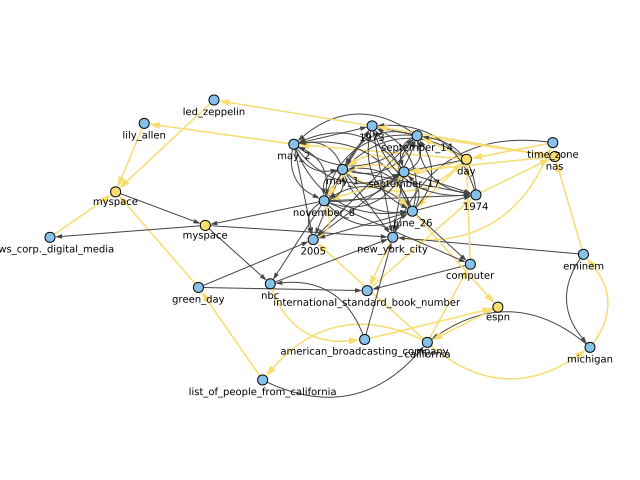

In [353]:
plot_subgraph(eg[2091], large=True)

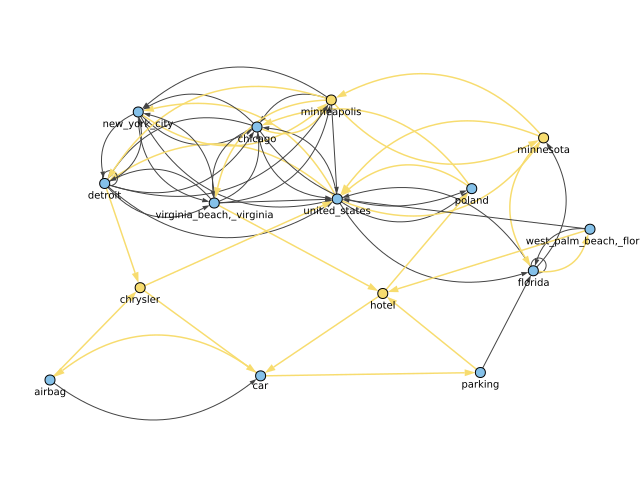

In [354]:
plot_subgraph(eg[4], large=True)

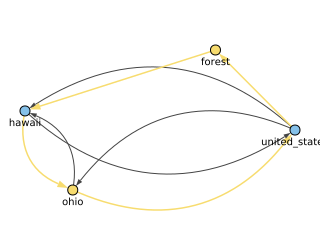

In [355]:
plot_subgraph(eg[2080])

### Distance between query entities

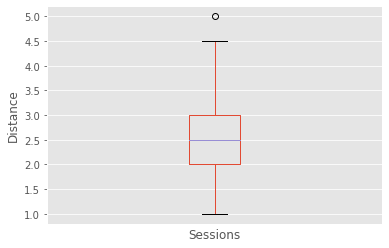

In [356]:
s_avg_dists = []
for session_id, sg in eg.items():
    s_dists = sg.shortest_paths(source=sg.vs.select(is_source=True), target=sg.vs.select(is_source=True))
    s_dists = list(filter(lambda x: x > 0, flatten(s_dists)))
    
    if len(s_dists) < 1 or np.inf in s_dists:
        continue
    
    s_avg_dist = np.mean(s_dists)
    s_avg_dists.append(s_avg_dist)

s_avg_dists = pd.DataFrame(s_avg_dists, columns=['avg_dist'])

plt.rc('figure', figsize=[6, 4])

s_avg_dists \
    .boxplot()

plt.xticks([])
plt.xlabel("Sessions")
plt.ylabel("Distance")

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Global entity importance (PageRank)

In [357]:
session_ids = []
pr = []
lpr = []

for session_id in top_sessions.index:
    if session_id in eg:
        for v in eg[session_id].vs:
            session_ids.append(session_id)
            pr.append(v['pr'])
            lpr.append(v['lpr'])

session_pr = pd.DataFrame({ 'session_id': session_ids, 'page_rank': pr, 'local_page_rank': lpr }) \
    .set_index('session_id')

session_pr.index = pd.Categorical(session_pr.index, categories=top_sessions.index)
session_pr.index.name = 'session_id'

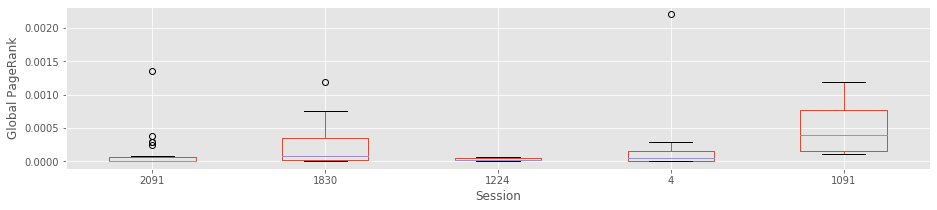

In [358]:
session_pr[['page_rank']] \
    .boxplot(by='session_id')

plt.xlabel("Session")
plt.ylabel("Global PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

### Local entity importance (PageRank)

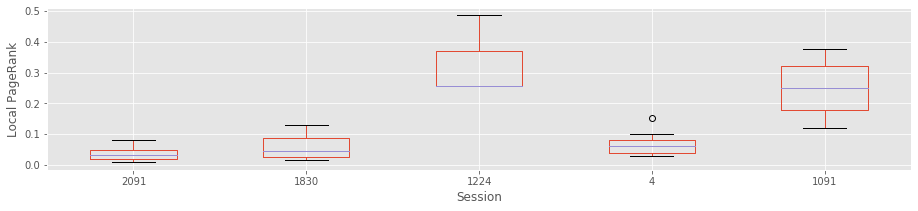

In [359]:
session_pr[['local_page_rank']] \
    .boxplot(by='session_id')

plt.xlabel("Session")
plt.ylabel("Local PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

### Global vs local PageRank

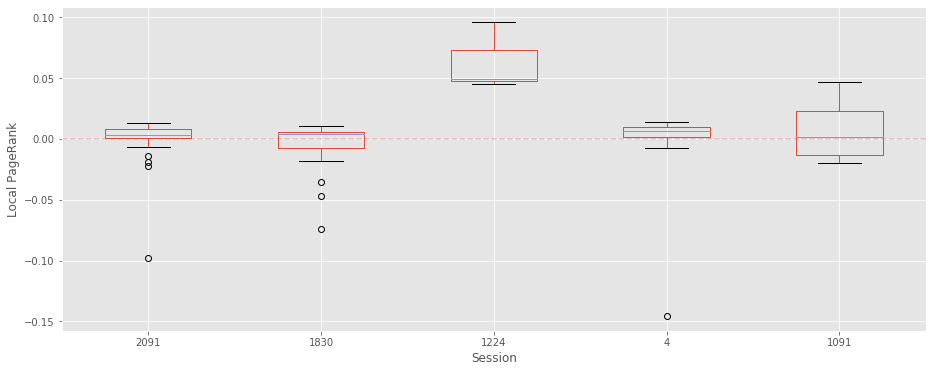

In [360]:
session_pr['norm_page_rank'] = session_pr['page_rank'] / session_pr['page_rank'].sum()
session_pr['norm_local_page_rank'] = session_pr['local_page_rank'] / session_pr['local_page_rank'].sum()
session_pr['norm_page_rank_diff'] = session_pr['norm_local_page_rank'] - session_pr['norm_page_rank']

plt.rc('figure', figsize=[DEFAULT_FIGSIZE[0], 6])

session_pr[['norm_page_rank_diff']] \
    .boxplot(by='session_id') \
    .axhline(y=0, alpha=0.3, linestyle='--')

plt.xlabel("Session")
plt.ylabel("Local PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

**Q:** Why does session 1224 show a higher absolute difference than the remaining sessions?

**H1:** Is it because of the number of queries?

In [361]:
session_queries = qlog[qlog['entities'].map(lambda e: len(e) if e else 0) > 0][['session_id', 'query']] \
    .set_index('session_id') \
    .loc[top_sessions.index]

session_queries.index = pd.Categorical(session_queries.index, categories=top_sessions.index)
session_queries.index.name = 'session_id'

session_queries \
    .groupby(['session_id']) \
    .nunique() \
    .reset_index()

,session_id,query
0,2091,7
1,1830,4
2,1224,6
3,4,4
4,1091,4


No. The behavior is simular for sessions 2091 and 1224 for the number of queries, but the highest change in PageRank was for session 1224.

**H2:** Is it because of the number of entities?

In [362]:
top_sessions \
    .reset_index() \
    .rename({ 0: 'entity' }, axis=1)

,session_id,entity
0,2091,8
1,1830,7
2,1224,7
3,4,6
4,1091,5


No. The behavior was similar for sessions 2091 and 1224 in number of entities, but the highest change in PageRank was for session 1224.

**H3:** Is is because of the semantics of the queries?

In [363]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    query_count_per_session = session_queries \
        .groupby(['session_id', 'query']) \
        .size() \
        .reset_index() \
        .rename({ 0: 'count'}, axis=1) \
        .sort_values(by=['session_id', 'count'], ascending=[True, False])
    
    query_count_per_session['query_length'] = query_count_per_session['query'].map(len)
    
    display(query_count_per_session)

,session_id,query,count,query_length
4,2091,myspace icons,2,13
0,2091,espn,1,4
1,2091,frank sinatra,1,13
2,2091,green day,1,9
3,2091,jay z,1,5
5,2091,nas,1,3
6,2091,toto cutugno,1,12
8,1830,new york port authority,2,23
9,1830,new york port authority bus information,2,39
7,1830,new jersey transit,1,18


Although the sample is too small, there seems to be a relation between query length and the change in PageRank. We investigate further, using the entity subgraphs for all sessions instead of the top sessions (i.e., with a higher number of distinct entities).

In [364]:
all_session_pr = pd.concat(
    pd.DataFrame({ 'session_id': session_id, 'pr': eg[session_id].vs['pr'], 'lpr': eg[session_id].vs['lpr'] })
    for session_id in eg.keys())

all_session_pr = all_session_pr \
    .set_index('session_id')

all_session_pr['pr'] = all_session_pr['pr'] / all_session_pr['pr'].sum()
all_session_pr['lpr'] = all_session_pr['lpr'] / all_session_pr['lpr'].sum()

all_session_pr = all_session_pr \
    .groupby('session_id') \
    .mean()

all_session_pr['pr_diff'] = all_session_pr['lpr'] - all_session_pr['pr']

all_session_pr = all_session_pr.merge(
    qlog[qlog['entities'].map(lambda e: len(e) if e else 0) > 0][['session_id', 'length']] \
        .groupby('session_id') \
        .mean(), on='session_id')

all_session_pr['pr_diff'].corr(all_session_pr['length'], method='spearman')

-0.14732450158788035

Based on the mean PageRanks and query lengths per session, there is no correlation with the change in PageRanks. Since the difference is so small, this is probably a random difference that we can disregard.

### Distribution of global entity importance (PageRank) per session

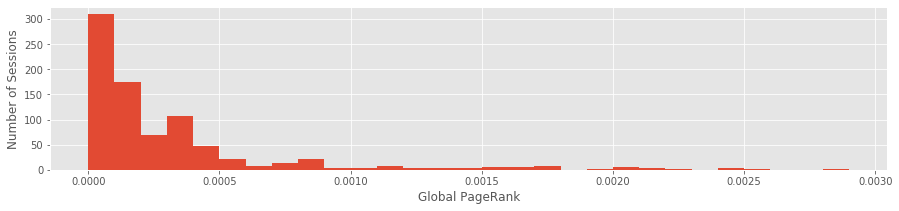

In [365]:
d_max = all_session_pr['pr'].max()
bin_width= 0.0001

all_session_pr['pr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Global PageRank')
plt.ylabel('Number of Sessions')
plt.show()

### Distribution of local entity importance (PageRank) per session

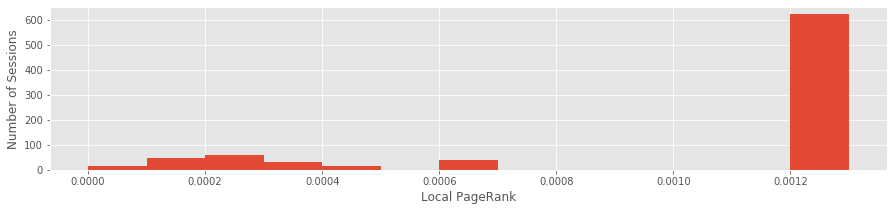

In [366]:
d_max = all_session_pr['lpr'].max()
bin_width= 0.0001

all_session_pr['lpr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Local PageRank')
plt.ylabel('Number of Sessions')
plt.show()

## Entity-term-level analysis

- Distribution of entities per query length (in number of terms)
- Distribution of terms per entity

### Distribution of entities per query length (in number of terms)

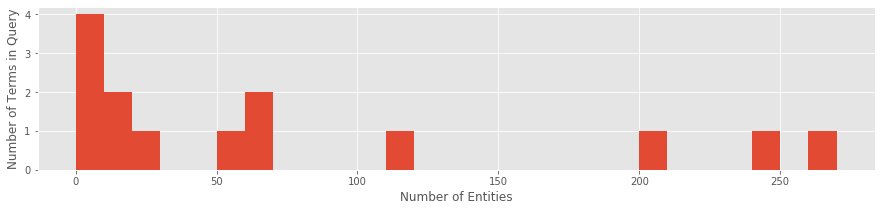

In [367]:
entities_per_query_num_terms = qlog[['num_terms', 'entities']] \
    .groupby('num_terms') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_query_num_terms \
    .plot(kind='hist', bins=range(0, entities_per_query_num_terms.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Terms in Query")
plt.show()

### Distribution of terms per entity (top 25)

In [368]:
unique_entities = np.unique([
    entity for entities in qlog['entities'] if entities
    for entity in entities])

terms_per_entity = pd.DataFrame({'entity': unique_entities})
terms_per_entity['entity_num_terms'] = terms_per_entity['entity'].map(lambda entity: len(entity.split(' ')))

terms_per_entity = terms_per_entity \
    .sort_values(by='entity_num_terms', ascending=False)

terms_per_entity

,entity,entity_num_terms
471,oklahoma city university school of law,6
553,san diego gas & electric,5
113,colorado bend state park,4
673,victor central school district,4
...,...,...
410,minneapolis,1
409,minerva,1
408,minds,1
353,latin,1


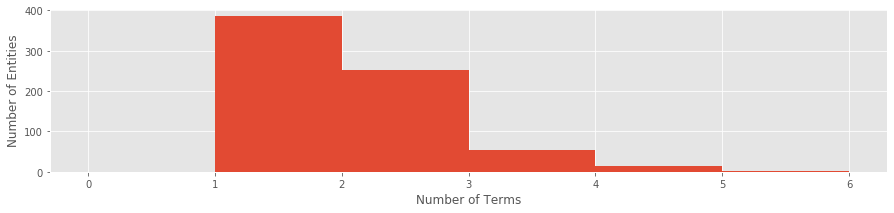

In [369]:
d_max = terms_per_entity['entity_num_terms'].max()
bin_width = 1

terms_per_entity['entity_num_terms'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel('Number of Terms')
plt.ylabel('Number of Entities')
plt.show()

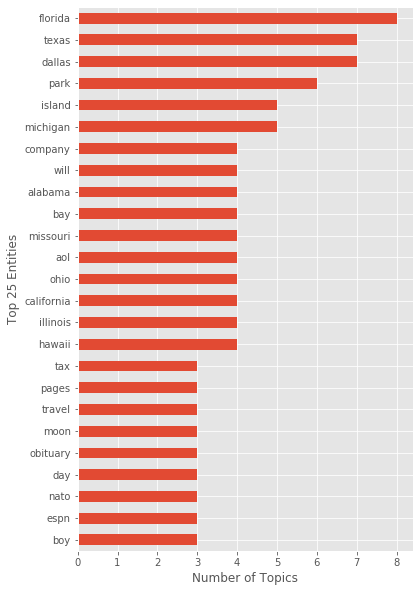

In [370]:
plt.rc('figure', figsize=[6, 10])

topics_per_entity['topic'] \
    .plot(kind='barh')
plt.xlabel('Number of Topics')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Entity-entity-level analysis

- Entity co-occurrence graph
  - Entity co-occurrence graph vs Simple Wikipedia link graph
    - Indegree correlation
    - PageRank correlation
    - Closeness centrality correlation
    - Betweenness centrality correlation

### Entity co-occurrence graph

#### Building and characterizing the entity co-occurrence graph

In [371]:
@memory.cache
def build_entity_cooccurrence_graph():
    g = igraph.Graph()
    
    graph = {}
    
    for t in qlog.itertuples():
        if t.entities is None:
            continue
        
        for source in t.entities:
            if not source in graph:
                graph[source] = {}
            
            for target in t.entities:
                if source != target:
                    if not target in graph[source]:
                        graph[source][target] = 1
                    else:
                        graph[source][target] += 1

    g.add_vertices(iter(graph.keys()))
    edges = [(source, target) for source in graph.keys() for target in graph[source].keys()]
    edges = [edge for edge in edges if edge[0] > edge[1]]
    g.add_edges(edges)
    
    return g

cg = build_entity_cooccurrence_graph()

In [372]:
cg_stats = compute_stats(cg); cg_stats

vertices          707.000000
edges             257.000000
avg_clust_coef      0.403587
density             0.001030
num_cc            501.000000
avg_cc_size         1.411178
stdev_cc_size       2.554514
dtype: float64

In [396]:
cg.vs['in'] = cg.indegree()
cg.vs['pr'] = cg.pagerank()
cg.vs['cc'] = cg.closeness()
cg.vs['bc'] = cg.betweenness()
cg.vs['label'] = cg.vs['name']

#### Visualizing the entity co-occurrence graph

Below we plot the components with more than three nodes.

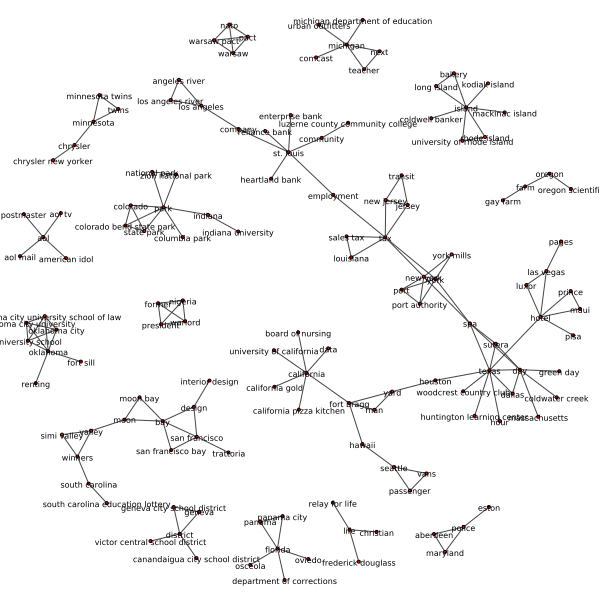

In [397]:
cg_components = [cg_component for cg_component in cg.components() if len(cg_component) > 3]
igraph.plot(cg.subgraph(flatten(cg_components)), vertex_size=3, vertex_label_size=8)

### Entity co-occurrence graph vs Simple Wikipedia link graph

First, we prepare the Simple Wikipedia subgraph containing only the entity nodes in the co-occurrence graph.

In [375]:
sg = g.subgraph(g.vs.select(label_in=cg.vs['label']))

In [394]:
sg.vs['in'] = sg.indegree()
sg.vs['pr'] = sg.pagerank()
sg.vs['cc'] = sg.closeness()
sg.vs['bc'] = sg.betweenness()

In [376]:
sg_stats = compute_stats(sg); sg_stats

vertices           358.000000
edges             1552.000000
avg_clust_coef       0.700346
density              0.012143
num_cc             241.000000
avg_cc_size          1.485477
stdev_cc_size        6.629558
dtype: float64

#### Indegree correlation

In [390]:
sg_in = pd.DataFrame({ 'entity': sg.vs['label'], 'in_sg': sg.vs['in'] })
cg_in = pd.DataFrame({ 'entity': cg.vs['label'], 'in_cg': cg.vs['in'] })
df_in = sg_in.merge(cg_in)
df_in['in_sg'].corr(df_in['in_cg'])

0.2444441834565536

#### PageRank correlation

In [391]:
sg_pr = pd.DataFrame({ 'entity': sg.vs['label'], 'pr_sg': sg.vs['pr'] })
cg_pr = pd.DataFrame({ 'entity': cg.vs['label'], 'pr_cg': cg.vs['pr'] })
df_pr = sg_pr.merge(cg_pr)
df_pr['pr_sg'].corr(df_pr['pr_cg'])

0.20622073644796002

#### Closeness centrality correlation

In [398]:
sg_cc = pd.DataFrame({ 'entity': sg.vs['label'], 'cc_sg': sg.vs['cc'] })
cg_cc = pd.DataFrame({ 'entity': cg.vs['label'], 'cc_cg': cg.vs['cc'] })
df_cc = sg_cc.merge(cg_cc)
df_cc['cc_sg'].corr(df_cc['cc_cg'])

0.1067526533029727

#### Betweenness centrality correlation

In [399]:
sg_bc = pd.DataFrame({ 'entity': sg.vs['label'], 'bc_sg': sg.vs['bc'] })
cg_bc = pd.DataFrame({ 'entity': cg.vs['label'], 'bc_cg': cg.vs['bc'] })
df_bc = sg_bc.merge(cg_bc)
df_bc['bc_sg'].corr(df_bc['bc_cg'])

0.07713627173530872

## Entity-session-query-level analysis

- Distribution of average number of entities per session over time
- Distribution of average entity importance (PageRank) per session over time

### Distribution of average number of entities per session over time

In [421]:
entities_per_session_over_time = pd.DataFrame(qlog[['query', 'session_id', 'entities', 'timestamp']])

entities_per_session_over_time['entities'] = \
    entities_per_session_over_time['entities'].map(lambda e: len(e) if e else 0)

entities_per_session_over_time['delta_time'] = entities_per_session_over_time[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .transform(lambda x: x - x.min())

entities_per_session_over_time = entities_per_session_over_time \
    .groupby(['session_id', 'delta_time']) \
    .sum() \
    .reset_index()[['delta_time', 'entities']] \
    .groupby('delta_time') \
    .mean() \
    .rolling(window=30) \
    .mean()

entities_per_session_over_time.index = pd.to_datetime(
    entities_per_session_over_time.index.map(lambda t: int(t.total_seconds())),
    unit='s')

entities_per_session_over_time

,entities
delta_time,
1970-01-01 00:00:00,NaN
1970-01-01 00:00:01,NaN
1970-01-01 00:00:02,NaN
1970-01-01 00:00:03,NaN
...,...
1970-01-01 02:37:32,0.250000
1970-01-01 02:39:20,0.250000
1970-01-01 03:04:40,0.266667
1970-01-01 03:25:45,0.300000


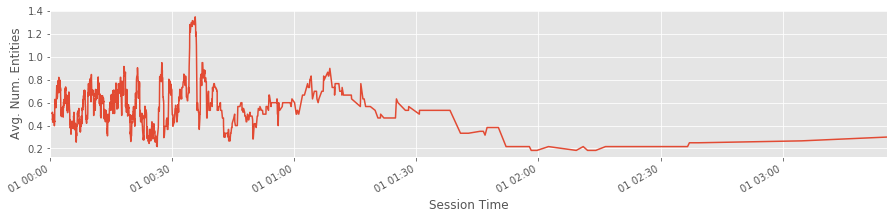

In [422]:
entities_per_session_over_time \
    .plot(kind='line', legend=False)
plt.xlabel('Session Time')
plt.ylabel('Avg. Num. Entities')
plt.show()

### Distribution of average entity importance (PageRank) per session over time

In [423]:
@memory.cache
def compute_entity_importance_per_session_over_time():
    entity_importance_per_session_over_time = pd.DataFrame(qlog[['query', 'session_id', 'entities', 'timestamp']])

    def entities_to_pagerank(entities):
        pr_v = []
        for entity in entities:
            try:
                pr_v.append(g.vs.find(label=entity)['pr'])
            except ValueError:
                pr_v.append(0)
        return pr_v

    entity_importance_per_session_over_time['avg_pr'] = \
        entity_importance_per_session_over_time['entities'] \
            .map(lambda e: np.mean(entities_to_pagerank(e)) if e else 0)

    entity_importance_per_session_over_time['delta_time'] = \
        entity_importance_per_session_over_time[['session_id', 'timestamp']] \
            .groupby('session_id') \
            .transform(lambda x: x - x.min())

    entity_importance_per_session_over_time = entity_importance_per_session_over_time \
        .groupby(['session_id', 'delta_time']) \
        .sum() \
        .reset_index()[['delta_time', 'avg_pr']] \
        .groupby('delta_time') \
        .mean() \
        .rolling(window=30) \
        .mean()

    entity_importance_per_session_over_time.index = pd.to_datetime(
        entity_importance_per_session_over_time.index.map(lambda t: int(t.total_seconds())),
        unit='s')

    return entity_importance_per_session_over_time

entity_importance_per_session_over_time = compute_entity_importance_per_session_over_time()
entity_importance_per_session_over_time

,avg_pr
delta_time,
1970-01-01 00:00:00,NaN
1970-01-01 00:00:01,NaN
1970-01-01 00:00:02,NaN
1970-01-01 00:00:03,NaN
...,...
1970-01-01 02:37:32,0.000003
1970-01-01 02:39:20,0.000003
1970-01-01 03:04:40,0.000003
1970-01-01 03:25:45,0.000003


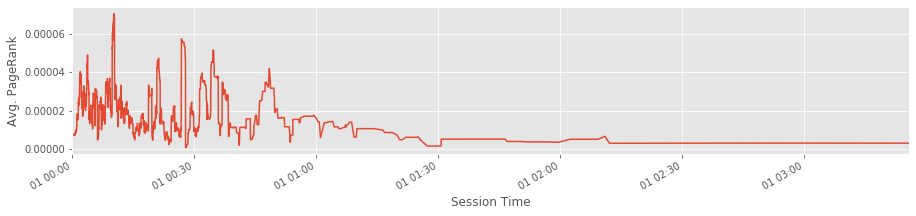

In [424]:
entity_importance_per_session_over_time \
    .plot(kind='line', legend=False)
plt.xlabel('Session Time')
plt.ylabel('Avg. PageRank')
plt.show()